# Nonlinearities

In [1]:
#import time
from tqdm import tqdm
#from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt

#import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

import torch
from torch import nn
from torchsummary import summary

(240, 2) (60, 2) (240,) (60,)


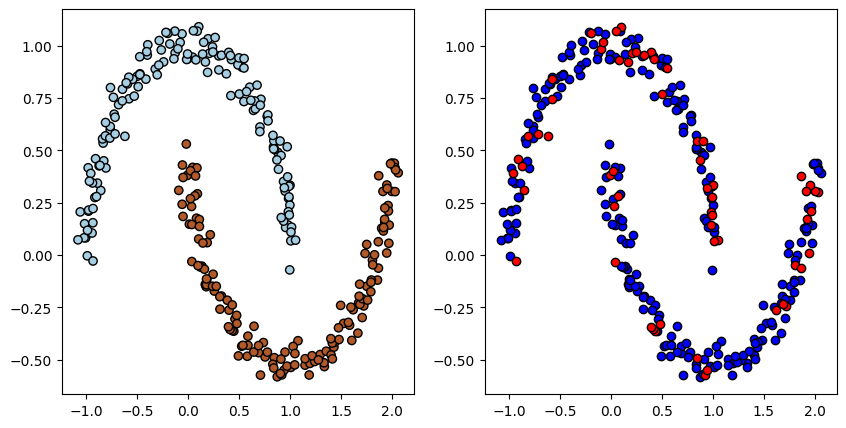

In [14]:
# Configuration options
num_classes = 2
X, y = make_moons(n_samples=300, noise=0.05)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 1)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

_, axes = plt.subplots (1,2, figsize=(10,5))

axes[0].scatter( X[:, 0], X[:, 1], c = y, edgecolors='k', cmap='Paired')
axes[1].scatter( X_train[:, 0], X_train[:, 1], edgecolors='k', c="b")
axes[1].scatter( X_test[:, 0], X_test[:, 1] , edgecolors='k', c="r");

In [3]:
# # Convert into greyscale
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [4]:
# Convert target classes to categorical ones
#y_train = to_categorical(y_train, num_classes)
#y_test = to_categorical(y_test, num_classes)

# Set the input shape
input_shape = (X_train.shape)
print(f'Feature shape: {input_shape}')

Feature shape: (240, 2)


In [5]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(240, 2) (60, 2) (240, 1) (60, 1)


## Create a graph model

In [6]:
model = nn.Sequential(
  nn.Linear(2, 10), nn.ReLU(), #1st layer  | (input)
  nn.Linear(10, 10), nn.ReLU(), #2nd layer | hidden
  nn.Linear(10, 10), nn.ReLU(), #3rd layer | hidden
  nn.Linear(10, 1), nn.Sigmoid() #4th layer| (output)
)

# model.cuda()

summary(model, input_size=(2,), device='cpu') #Importante mantener el formato tupla con esos valores
# print (model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
              ReLU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              ReLU-4                   [-1, 10]               0
            Linear-5                   [-1, 10]             110
              ReLU-6                   [-1, 10]               0
            Linear-7                    [-1, 1]              11
           Sigmoid-8                    [-1, 1]               0
Total params: 261
Trainable params: 261
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Define loss function and optimizer

In [8]:
loss = nn.MSELoss()  #nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  #torch.optim.Adam(model.parameters(), lr = 1e-3)

# model.cuda()
# loss.cuda()

## Train model

In [9]:
epochs = 800
batch_size = 50
losses = []

# start_time = time.time()
progress = tqdm(range(epochs), ncols=110)

for epoch in progress:

  batch_losses = 0

  for batch_i in range(0, len(X_train), batch_size):

    batch_X = X_train[ batch_i: batch_i + batch_size ]
    batch_y = y_train[ batch_i : batch_i + batch_size ]
    batch_X = torch.from_numpy(batch_X).to(torch.float32)#.cuda()
    batch_y = torch.from_numpy(batch_y).to(torch.float32)#.cuda()

    # 1. Zero the gradients
    optimizer.zero_grad()

    # 2. Perform forward pass
    predictions = model(batch_X)

    # 3. Compute loss
    batch_loss = loss( batch_y, predictions)

    # 4. Perform backward pass
    batch_loss.backward()

    # 5. Optimize parameters
    optimizer.step()

    ## Save stats
    batch_losses += batch_loss.item()

    # elapsed_time = time.time() - start_time
  epoch_loss = batch_losses/(len(X_train)/batch_size)
  progress.set_description("Epoch [%d/%d] [Loss: %f]" % (epoch, epochs, epoch_loss))

  losses.append(epoch_loss)


Epoch [799/800] [Loss: 0.000377]: 100%|████████████████████████████████████| 800/800 [00:05<00:00, 138.83it/s]


## Plot results

Text(0.5, 0, 'Epoch')

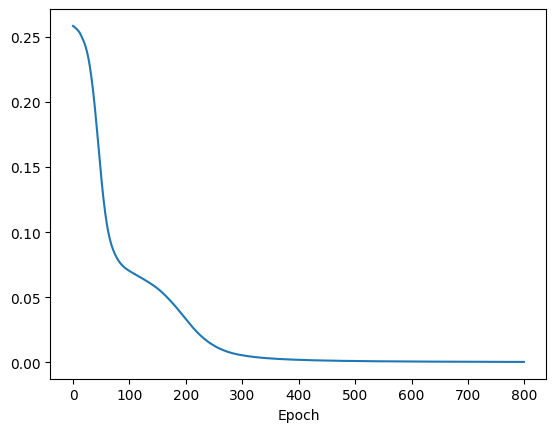

In [10]:
plt.plot(np.array(losses))
plt.xlabel("Epoch")

In [11]:
h_min, h_max = X_test[:, 0].min()-0.2, X_test[:, 0].max()+0.2
v_min, v_max = X_test[:, 1].min()-0.1, X_test[:, 1].max()+0.1

# Crear el grid de las fronteras de decision
h_grid, v_grid = np.meshgrid(np.linspace( h_min, h_max, 200), np.linspace( v_min, v_max, 200))

# Predecir los valores del grid
grid_ = torch.from_numpy(np.c_[h_grid.ravel(), v_grid.ravel()]).to(torch.float32)#.cuda()
pred_grid = model(grid_)

pred_grid = (pred_grid > 0.5) * 1
# print( pred_grid[0:10, 0], y_test[0:10,0])

# predictions = np.argmax( _, axis=1)
print (pred_grid.shape)

# Encajar las predicciones al tamaño del grid
pred_grid = pred_grid.detach().numpy().reshape(h_grid.shape)
print (pred_grid.shape)

torch.Size([40000, 1])
(200, 200)


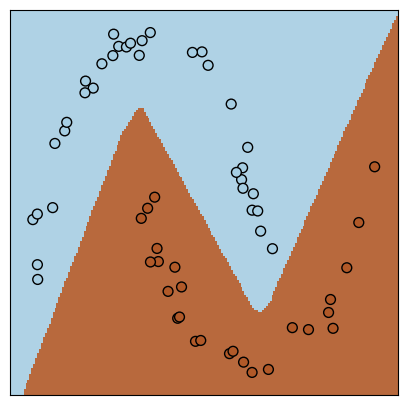

In [13]:
_, ax = plt.subplots (figsize=(5,5))

# Put the result into a color plot
plt.pcolormesh(h_grid, v_grid, pred_grid, cmap='Paired', alpha=0.9)

ax.scatter( X_test[:, 0], X_test[:, 1], c = y_test, edgecolors='k', s=50, cmap='Paired')

# ax.set_xlim(h_grid.min()-.1, h_grid.max()+.1)
# ax.set_ylim(v_grid.min()-.1, v_grid.max()+.1)

ax.set_xticks(())
ax.set_yticks(());